In [3]:
import os, sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

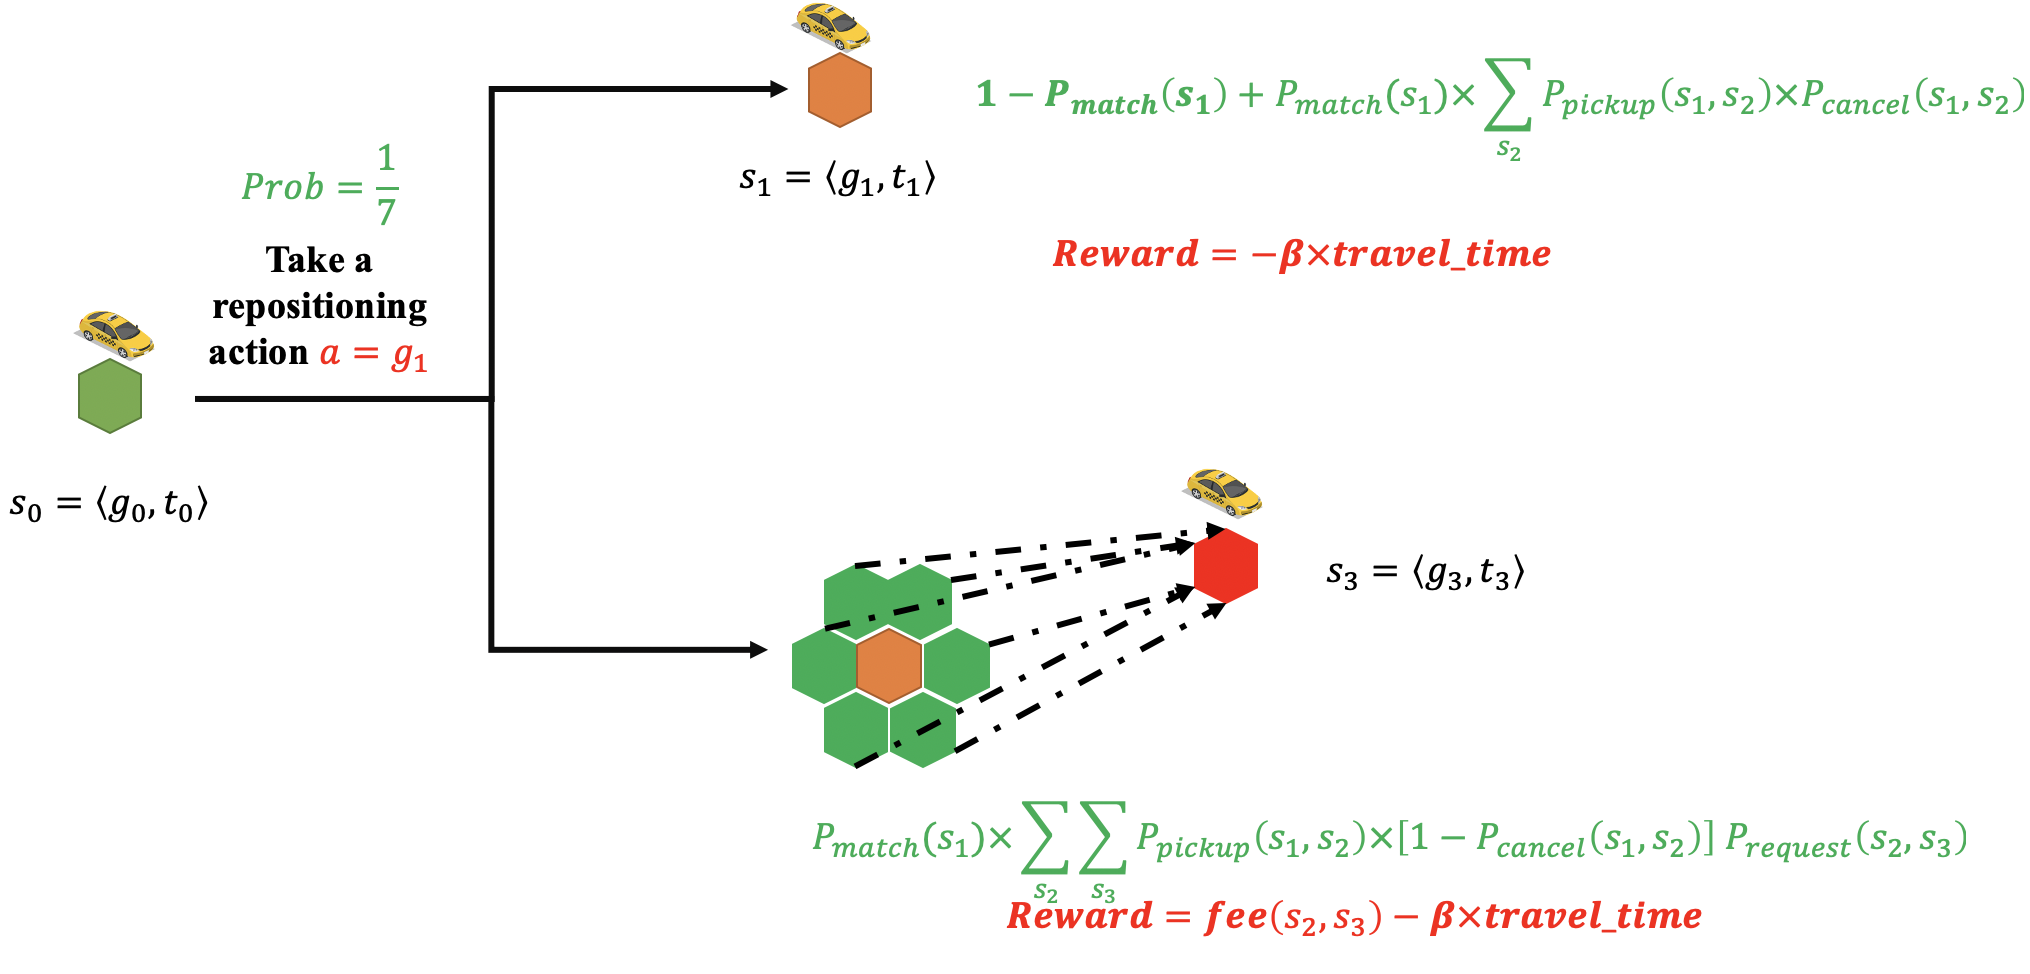

In [4]:
class Stamp_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_date(self,stamp):
        dateArray = datetime.datetime.fromtimestamp(stamp)
        otherStyleTime = dateArray.strftime("%Y-%m-%d %H:%M:%S")
        return otherStyleTime[:10]
    
    '''Time stamp'''
    def Get_stamp(self,time_str):
        timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
        timeStamp = int(time.mktime(timeArray))
        return timeStamp
    
    '''Time step'''
    def Get_step(self,stamp,date_str,step):
        baseline = date_str+" 00:00:00";
        baseline = int(self.Get_stamp(baseline))
        current_step=int((stamp-baseline)/step)
        return current_step
    
    def Get_datelist(self, beginDate, endDate):
        date_list=[datetime.datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
        return date_list
    
    def Get_weekday(self,date_str):
        date_str = date_str+" 00:00:00";
        date_str = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return date_str.tm_wday+1

    def Get_normalization(self,end_step,t_step):
        if t_step>=end_step:
            return t_step-end_step
        else:
            return t_step


class Spatial_calculation(object):
    
    def __init__(self, Zoom):
        """ Load your trained model and initialize the parameters """
        self.Zoom=Zoom
        self.CALCULATOR = dgckernel.Calculator()
        self.CALCULATOR.SetLayer(Zoom)
        
    '''GRID ID'''

    def get_grid(self,lng,lat):

        return self.CALCULATOR.HexCellKey(dgckernel.GeoCoord(lat, lng))

    '''GRID SHAPE'''

    def get_grid_shape(self,grid):

        return self.CALCULATOR.HexCellVertexesAndCenter(grid)
        
    '''Neighbor Grid'''

    def grid_neighbor(self, grid, low_layer, up_layer):

        neighbors = self.CALCULATOR.HexCellNeighbor(grid, up_layer)
        _neighbors = self.CALCULATOR.HexCellNeighbor(grid, low_layer)
        neighbors = [e for e in neighbors if e not in _neighbors]
        return neighbors 
    
    def grid_eliminate(self,grid_list,sw,ne):
        grid_result=list()
        for grid in grid_list:
            v_f,c_f=self.get_grid_shape(grid)
            c_lng,c_lat=c_f.lng,c_f.lat;
            if c_lng>=sw[1] and c_lng<=ne[1] and c_lat>=sw[0] and c_lat<=ne[0]:
                grid_result.append(grid)
        return grid_result
    
    def Geo_distance(self,lng1,lat1,lng2,lat2):
        lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) 
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
        distance=2*asin(sqrt(a))*6371 
        distance=round(distance,2)
        return distance
    
    '''Get Distance'''
    def get_grid_dis(self,f_grid,t_grid):

        f_shape,f_center=self.get_grid_shape(f_grid);
        t_shape,t_center=self.get_grid_shape(t_grid);

        Topology_dis=1.3*self.Geo_distance(f_center.lng,f_center.lat,t_center.lng,t_center.lat)

        return Topology_dis

# 0 Data initializing

In [12]:
'''Time range'''

end_step=144

spatial_calculation=Spatial_calculation(13)

stamp_transition=Stamp_transition()



'''Reward table'''

MODEL_PATH='./kddcup-testing/model/modelfile/'

All_grid = np.load(os.path.join(MODEL_PATH,'All_grid_weekend.npy'))

Reward_dic = np.load(os.path.join(MODEL_PATH,'Reward_dic_weekend.npy')).item()

Capacity_dic = np.load(os.path.join(MODEL_PATH,'Capacity_dic_weekend.npy')).item()

Dispatch_PROB = np.load(os.path.join(MODEL_PATH,'Dispatch_PROB_weekend.npy')).item()

Request_PROB = np.load(os.path.join(MODEL_PATH,'Request_PROB_weekend.npy')).item()


# 01 Modeling

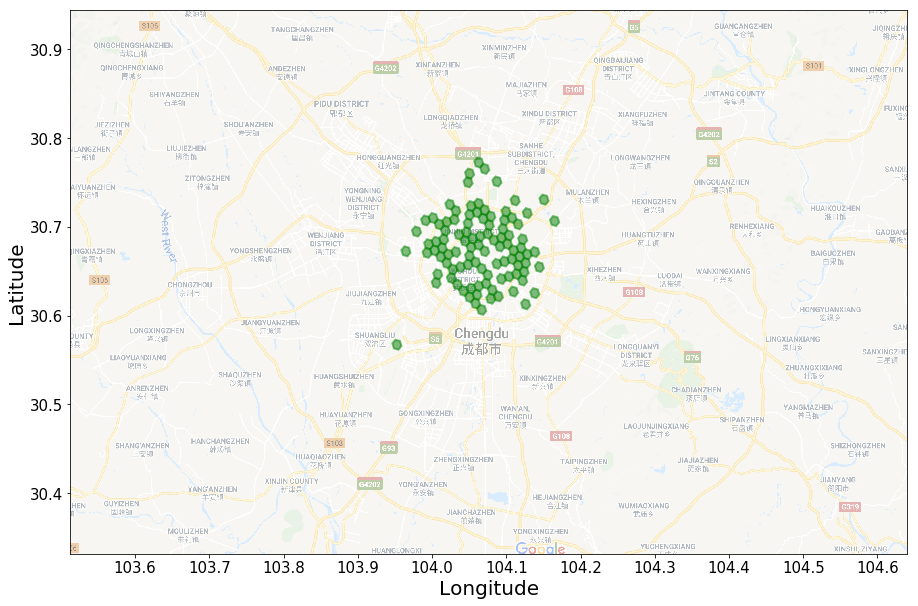

In [9]:
'''Overall range'''
southwest=[30.331759, 103.512892]
northeast=[30.944065, 104.640393]

def draw_bkg(sw,ne):
    
    '''Initial parameter'''
    bg_path='Chengdu.png'
    
    '''Figure out'''
    img = plt.imread(bg_path)
    height, width = img.shape[:2]
    h1 = math.ceil(15./width*height)
    fig = plt.figure(figsize=(15,h1))
    ax = fig.add_subplot(111)
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    plt.xlim(xgrange)
    plt.ylim(ygrange)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.xticks(np.arange(xgrange[0], xgrange[1], 0.352/15))
    plt.yticks(np.arange(ygrange[0], ygrange[1], 0.2415/13))
    try:
        ax.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
    except:
        pass
    return fig, ax, xgrange, ygrange



fig, ax, xgrange, ygrange=draw_bkg(southwest,northeast)

'''Axis'''

xmajorLocator   = MultipleLocator(0.1)
ymajorLocator   = MultipleLocator(0.1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)

for grid in All_grid:


    v_f,c_f=spatial_calculation.get_grid_shape(grid)


    pgon = plt.Polygon(([v_f[0].lng,v_f[0].lat], [v_f[1].lng,v_f[1].lat], [v_f[2].lng,v_f[2].lat]\
                            ,[v_f[3].lng,v_f[3].lat],[v_f[4].lng,v_f[4].lat],[v_f[5].lng,v_f[5].lat]),color='g',linewidth=2,fill=True,alpha=0.5)

    plt.gca().add_patch(pgon)


plt.tick_params(labelsize=15)

labels = ax.get_xticklabels() + ax.get_yticklabels()
font2 = {'weight': 'normal','size': 20}
plt.xlabel('Longitude', font2)
plt.ylabel('Latitude', font2)
plt.xlim((southwest[1], northeast[1]))
plt.ylim((southwest[0], northeast[0]))

plt.show()

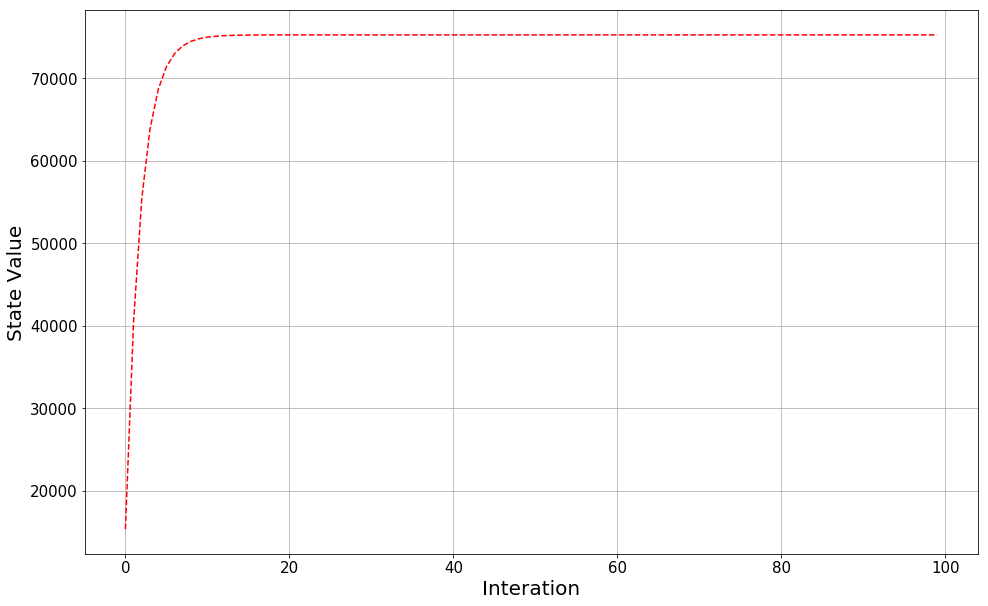

In [17]:
Value_record=pd.read_csv(os.path.join(MODEL_PATH,'Value_sum_weekend.csv'))
figsize = 16,10
figure,ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
font = {'weight' : 'normal','size': 20}

plt.plot(Value_record['iteration'],Value_record['V_sum'],'r--')
plt.xlabel('Interation',font)
plt.ylabel('State Value',font)
plt.grid()
plt.show()

In [20]:
Grid=np.load(os.path.join(MODEL_PATH,'Grid.npy'))

State_value_dic={}

for grid in Grid:
    
    for t_step in range(end_step):
        
        state=grid+'-'+str(t_step)
        
        State_value_dic[state]=0.0
        
        

State_value=pd.read_csv(os.path.join(MODEL_PATH,'State_value_weekend.csv'))

for idx,row in State_value.iterrows():
    
    state=row['State']
    
    State_value_dic[state]=row['value']


np.save(os.path.join(MODEL_PATH,'State_value_weekend'),State_value_dic)

State_value_dic


{'OL13F1i6552j1690-0': 0.0,
 'OL13F1i6552j1690-1': 0.0,
 'OL13F1i6552j1690-2': 0.0,
 'OL13F1i6552j1690-3': 0.0,
 'OL13F1i6552j1690-4': 0.0,
 'OL13F1i6552j1690-5': 0.0,
 'OL13F1i6552j1690-6': 0.0,
 'OL13F1i6552j1690-7': 0.0,
 'OL13F1i6552j1690-8': 0.0,
 'OL13F1i6552j1690-9': 0.0,
 'OL13F1i6552j1690-10': 0.0,
 'OL13F1i6552j1690-11': 0.0,
 'OL13F1i6552j1690-12': 0.0,
 'OL13F1i6552j1690-13': 0.0,
 'OL13F1i6552j1690-14': 0.0,
 'OL13F1i6552j1690-15': 0.0,
 'OL13F1i6552j1690-16': 0.0,
 'OL13F1i6552j1690-17': 0.0,
 'OL13F1i6552j1690-18': 0.0,
 'OL13F1i6552j1690-19': 0.0,
 'OL13F1i6552j1690-20': 0.0,
 'OL13F1i6552j1690-21': 0.0,
 'OL13F1i6552j1690-22': 0.0,
 'OL13F1i6552j1690-23': 0.0,
 'OL13F1i6552j1690-24': 0.0,
 'OL13F1i6552j1690-25': 0.0,
 'OL13F1i6552j1690-26': 0.0,
 'OL13F1i6552j1690-27': 0.0,
 'OL13F1i6552j1690-28': 0.0,
 'OL13F1i6552j1690-29': 0.0,
 'OL13F1i6552j1690-30': 0.0,
 'OL13F1i6552j1690-31': 0.0,
 'OL13F1i6552j1690-32': 0.0,
 'OL13F1i6552j1690-33': 0.0,
 'OL13F1i6552j1690-34': 